<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">


---
<h3>Jon Amelibia, Iker Cumplido, Aitor Hernandez, Daniel Puente and Iñigo Ugarte

## Index
---

- <a href='#1'><ins>1. Loading of Libraries and Data<ins></a>
- <a href='#2'><ins>2. Transform data to introduce it in RRNN<ins></a>
- <a href='#3'><ins>3. Custom loss function<ins> </a>
- <a href='#4'><ins>4. Save data<ins> </a>

### <a id='1'>1. Loading of Libraries and Data</a>
---

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

Plotting functions

In [3]:
def plotting_epochs(loss, val_loss):
    plt.figure(figsize = (26, 5))
    plt.plot(loss, color = 'darkblue', linewidth = 2, label = 'Train');
    plt.plot(val_loss, color = 'darkred', linewidth = 2, label = 'Validation');
    plt.title('Train vs Validation epochs', fontsize = 20), plt.xlabel('Epochs', fontsize = 15), plt.ylabel('Loss', fontsize = 15);
    plt.xlabel('Epochs'), plt.ylabel('Loss'); plt.legend(), plt.grid(linestyle='--',linewidth=1.5);
    plt.show();

Main variables

In [4]:
path_origin, path_processed = "../data/original_data/", "../data/processed_data/"
models_path = "../data/processed_data/models/"
palette = ['#264653','#2A9D8F','#85CAC2','#DFF6F4' ,'#E9C46A','#F4A261','#E76F51','#C53D1B', '#7E2711']
cells = [f'\Cell{x}\*' for x in range(1, 9)]
font = {'size': 16, 'color': 'black', 'weight': 'bold'}

Processed dataset

In [5]:
df_desc_final_pickle_load = pd.read_pickle(path_processed + 'df_desc_final.pkl')
df_desc_final_pickle = df_desc_final_pickle_load[df_desc_final_pickle_load.RUL >= 0 ]
df_desc_final_pickle["RUL"] = df_desc_final_pickle["RUL"].astype(float)
print(df_desc_final_pickle.shape)

(390, 41)


### <a id='2'>2. Transform data to introduce it in RRNN</a>
---

In [6]:
x, y, num_steps, percentage_and_rul = [], [], 10, []

for i in range(1, 9):
    batery_df = df_desc_final_pickle[df_desc_final_pickle.index.get_level_values(0) == i]
    batery_df.index = pd.MultiIndex.from_tuples([(1, x) for x in range(1, batery_df.shape[0] + 1)])
    for j in range(1, len(batery_df) - num_steps):

        x.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].drop(columns=['RUL']).values))
        y.append(np.array([batery_df.loc[(1, slice(j,num_steps+j)), :].RUL.values[-1], i]))
        # y.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].RUL.values[-1]))
        
x = np.array(x)
y = np.array(y)

# y = y.reshape(-1,1)
x.shape, y.shape

((302, 11, 40), (302, 2))

We split the data into train and test sets, and then we scale the data.

In [18]:
X_train,X_test,y_train_mod,y_test_mod = train_test_split(x, y,test_size=0.2, random_state=42, stratify=y[:,1])
y_train, y_test = y_train_mod[:,0].reshape(-1,1), y_test_mod[:,0].reshape(-1,1)

# X_train,X_test,y_train,y_test = train_test_split(x, y,test_size=0.2, random_state=42)

X_train = np.stack(X_train, axis = 0)
y_train = np.stack(y_train, axis = 0)

X_test = np.stack(X_test, axis = 0)
y_test = np.stack(y_test, axis = 0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

### <a id='3'>3. Custom loss function</a>
---

A loss function is created in order to penalisize the model when the prediction is greater than the real value.

In [20]:
def customLoss(true,pred):
    diff = pred - true
    greater = K.greater(diff,0)
    greater = K.cast(greater, K.floatx()) 
    greater = greater + 1                
    # return K.mean((2*greater) * K.square(diff))
    return K.mean(K.square(diff))*greater

def customLoss_numpy(true,pred):
    diff = pred - true
    greater = np.max(diff)
    greater = greater + 1     
    #return np.mean(diff**greater) 
    return np.mean(greater*(diff**2))

We apply the created function to small numbers to see the difference between the classic rmse and the customed one.

In [21]:
float_numbers = [x/100 for x in range(1,301)]
lista_mse, lista_mse_2 = [], []
for i in float_numbers:
    lista_mse.append(mean_squared_error([0], [i]))
    lista_mse_2.append(customLoss_numpy(np.array([0]),np.array([i])))  

We can see that out function is working as expected, penalizing more the errors when the true value is higher than the predicted value.

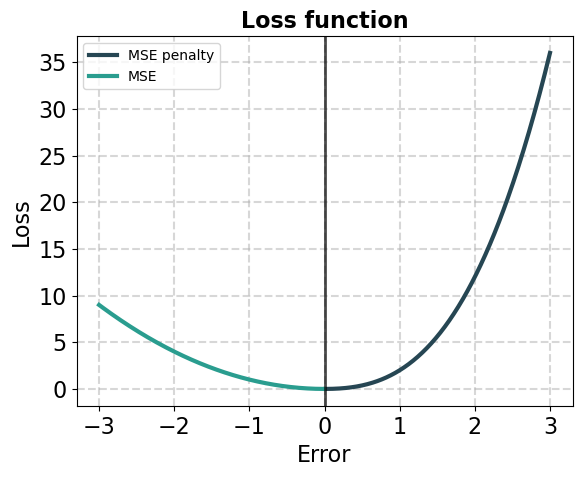

In [22]:
plt.plot(float_numbers, lista_mse_2, label='MSE penalty', color=palette[0], linewidth=3)
plt.plot(-np.array(float_numbers), lista_mse, label='MSE', color=palette[1], linewidth=3)
plt.legend(), plt.xticks(fontsize=16), plt.yticks(fontsize=16), plt.grid(linestyle='--',linewidth=1.5, alpha = 0.5);
plt.xlabel('Error', fontsize=16), plt.ylabel('Loss', fontsize=16), plt.title('Loss function', fontsize=16, fontweight='bold');
plt.axvline(x=0, color='black', linewidth=2, alpha = 0.7);

### Models
---

#### LSTM


In [ ]:
np.random.seed(26)
tf.random.set_seed(26)
checkpoint_first_model_LSTM = keras.callbacks.ModelCheckpoint('first_model_LSTM.h5', verbose=1, save_best_only=True)

model = keras.Sequential([
    keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=5000, batch_size=16, validation_split=0.2, verbose=0, shuffle=False, callbacks=[checkpoint_first_model_LSTM])


Epoch 1: val_loss improved from inf to 6233024.00000, saving model to first_model_LSTM.h5

Epoch 2: val_loss improved from 6233024.00000 to 6220902.00000, saving model to first_model_LSTM.h5


#### GRU

In [ ]:
np.random.seed(26)
tf.random.set_seed(26)
early_stopping = keras.callbacks.EarlyStopping(patience=10000, restore_best_weights=True, monitor='val_loss')
first_model_GRU_without_neg = keras.callbacks.ModelCheckpoint('first_model_GRU_without_neg.h5', verbose=0, save_best_only=True)

model2 = keras.Sequential([
    keras.layers.GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    keras.layers.GRU(64),
    keras.layers.Dense(1, activation='relu')
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss=customLoss, optimizer='adam', metrics=['mae'])
historyW = model2.fit(X_train, y_train, epochs=50000, batch_size=32, validation_split=0.2, verbose=0, shuffle=False, callbacks=[first_model_GRU_without_neg, early_stopping])

#### Bidirectional
**LSTM**

In [21]:
def customLoss(true,pred):
    diff = pred - true
    greater = K.greater(diff,0)
    greater = K.cast(greater, K.floatx()) 
    greater = greater + 1                
    return K.mean(K.square(diff))*greater

np.random.seed(26), tf.random.set_seed(26);
early_stopping = keras.callbacks.EarlyStopping(patience=5000, restore_best_weights=True)
checkpoint_first_model_Bi_LSTM = keras.callbacks.ModelCheckpoint('first_model_Bidirectional_LSTM_good.h5', verbose = 0, save_best_only=True)

model_lstm_bidirectional = keras.Sequential()
forward_layer = keras.layers.LSTM(512) #256
backward_layer = keras.layers.LSTM(512, go_backwards = True)
model_lstm_bidirectional.add(keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(X_train.shape[1], X_train.shape[2]) ))
model_lstm_bidirectional.add(keras.layers.Dense(1, activation='relu'))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_lstm_bidirectional.compile(loss=customLoss, optimizer= optimizer, metrics=['mae'])
historyBiLSTM = model_lstm_bidirectional.fit(X_train, y_train, epochs=20000, batch_size=16, validation_split=0.2, verbose=0, shuffle=False, callbacks=[checkpoint_first_model_Bi_LSTM, early_stopping])

**GRU**

In [ ]:
np.random.seed(26)
tf.random.set_seed(26)
early_stopping = keras.callbacks.EarlyStopping(patience=25000, restore_best_weights=True)
checkpoint_first_model_Bi_LSTM = keras.callbacks.ModelCheckpoint('first_model_Bidirectional_GRU.h5', verbose = 0, save_best_only=True)

model_lstm_bidirectional = keras.Sequential()
forward_layer = keras.layers.GRU(256)
backward_layer = keras.layers.GRU(256, go_backwards = True)
model_lstm_bidirectional.add(keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(X_train.shape[1], X_train.shape[2]) ))
model_lstm_bidirectional.add(keras.layers.Dense(1, activation='relu'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_lstm_bidirectional.compile(loss=customLoss, optimizer= optimizer, metrics=['mae'])
historyBiLSTM = model_lstm_bidirectional.fit(X_train, y_train, epochs=50000, batch_size=32, validation_split=0.2, verbose=0, shuffle=False, callbacks=[checkpoint_first_model_Bi_LSTM, early_stopping])

### Results
---

In [ ]:
model = keras.models.load_model(models_path + 'first_model_GRU_without_neg.h5', custom_objects={'customLoss': customLoss})
ypred_train = model.predict(X_train)
print(r2_score(y_train, ypred_train), mean_absolute_error(y_train, ypred_train), np.sqrt(mean_squared_error(y_train, ypred_train)))
ypred = model.predict(X_test)
print(r2_score(y_test, ypred), mean_absolute_error(y_test, ypred), np.sqrt(mean_squared_error(y_test, ypred)))

7/7 [==============================] - 1s 4ms/step
0.9954333735230104 41.073690520392525 81.65105564061942
2/2 [==============================] - 0s 6ms/step
0.976863396598865 146.8366680851689 186.75194068367335


In [34]:
# model = keras.models.load_model(models_path + 'first_model_Bidirectional_LSTM_2.h5', custom_objects={'customLoss': customLoss})
model = keras.models.load_model(models_path + 'first_model_Bidirectional_LSTM_good.h5', custom_objects={'customLoss': customLoss})

ypred_train = model.predict(X_train)
print(r2_score(y_train, ypred_train), mean_absolute_error(y_train, ypred_train), np.sqrt(mean_squared_error(y_train, ypred_train)))
ypred = model.predict(X_test)
print(r2_score(y_test, ypred), mean_absolute_error(y_test, ypred), np.sqrt(mean_squared_error(y_test, ypred)))

8/8 [==============================] - 1s 44ms/step
0.9975165066930479 26.621294013692136 68.90378403029484
2/2 [==============================] - 0s 48ms/step
0.995757187180277 57.91835497246414 76.58240596764526


In [ ]:
model = keras.models.load_model(models_path + 'first_model_Bidirectional_LSTM_exp.h5', custom_objects={'customLoss': customLoss})
ypred_train = model.predict(X_train)
print(r2_score(y_train, ypred_train), mean_absolute_error(y_train, ypred_train), np.sqrt(mean_squared_error(y_train, ypred_train)))
ypred = model.predict(X_test)
print(r2_score(y_test, ypred), mean_absolute_error(y_test, ypred), np.sqrt(mean_squared_error(y_test, ypred)))

7/7 [==============================] - 1s 12ms/step
0.10624787577584249 869.0566813658785 1142.2800774211476
2/2 [==============================] - 0s 7ms/step
0.1891737846926307 843.1292919229578 1105.5520987608147


In [16]:
model = keras.models.load_model(models_path + 'first_model_Bidirectional_GRU.h5', custom_objects={'customLoss': customLoss})
ypred_train = model.predict(X_train)
print(r2_score(y_train, ypred_train), mean_absolute_error(y_train, ypred_train), np.sqrt(mean_squared_error(y_train, ypred_train)))
ypred = model.predict(X_test)
print(r2_score(y_test, ypred), mean_absolute_error(y_test, ypred), np.sqrt(mean_squared_error(y_test, ypred)))

7/7 [==============================] - 1s 5ms/step
0.997041220981079 28.057910601298016 65.72344566470753
2/2 [==============================] - 0s 5ms/step
0.9827192907625739 108.41561239737051 161.39724009334756


### Plotting results
---

In [23]:
model = keras.models.load_model(models_path + 'first_model_Bidirectional_LSTM_good.h5', custom_objects={'customLoss': customLoss})

ypred_train = model.predict(X_train)
print(r2_score(y_train, ypred_train), mean_absolute_error(y_train, ypred_train), np.sqrt(mean_squared_error(y_train, ypred_train)))
ypred = model.predict(X_test)
print(r2_score(y_test, ypred), mean_absolute_error(y_test, ypred), np.sqrt(mean_squared_error(y_test, ypred)))

8/8 [==============================] - 1s 47ms/step
0.9976767917778457 31.314048735432603 64.16841963052248
2/2 [==============================] - 0s 54ms/step
0.9955403600684319 43.56285270315702 92.83834493294862


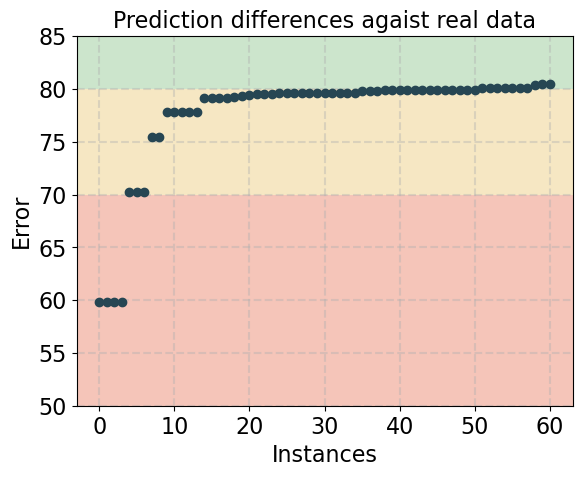

In [103]:
differences = (y_test - ypred).flatten()
list_soh = []
for k, v in enumerate(differences):
    df_modify = df_desc_final_pickle_load.loc[y_test_mod[:,1][k],:]
    if len(df_modify[df_modify['RUL']<v]) == 0: list_soh.append(df_modify[df_modify['RUL']>v].tail(1)['SoH_max_ch'].values[0])
    else: list_soh.append(    np.mean([  df_modify[df_modify['RUL']<v].head(1)['SoH_max_ch'].values[0], df_modify[df_modify['RUL']>v].tail(1)['SoH_max_ch'].values[0] ]   )   )

plt.plot(np.sort(list_soh), 'bo', color='#264653', linewidth=2)
plt.xticks(fontsize=16), plt.yticks(fontsize=16), plt.grid(linestyle='--',linewidth=1.5, alpha = 0.4);
plt.xlabel('Instances', fontsize=16), plt.ylabel('Error', fontsize=16), plt.title('Prediction differences agaist real data', fontsize=16);
plt.axhspan(70, 50, facecolor=palette[6], alpha=0.4), plt.axhspan(80, 70, facecolor=palette[4], alpha=0.4), plt.axhspan(85, 80, facecolor='g', alpha=0.2), plt.ylim(50, 85);

# plt.annotate(f"{len(diff_ordered[diff_ordered >= 0])}", xy=(10, 100), xytext=(10, 100), fontsize=16, color='k', fontweight='bold');
# plt.annotate(f"{len(diff_ordered[diff_ordered < 0])}", xy=(35, -100), xytext=(35, -100), fontsize=16, color='k', fontweight='bold');

In [61]:
intervals = pd.cut(df_compare['soh'], bins=[50, 70, 80, 100], labels=['Bad', 'Medium', 'Good'])
df_compare = pd.DataFrame([y_test_mod[:,1], list_soh]).T
df_compare.columns = ['bateries', 'soh']
df_compare['state'] = intervals
df_compare.bateries = df_compare.bateries.astype(int)
df_compare[df_compare['state']=='Bad']

,bateries,soh,state
28,5,59.814391,Bad
36,5,59.814391,Bad
49,5,59.814391,Bad
58,5,59.814391,Bad


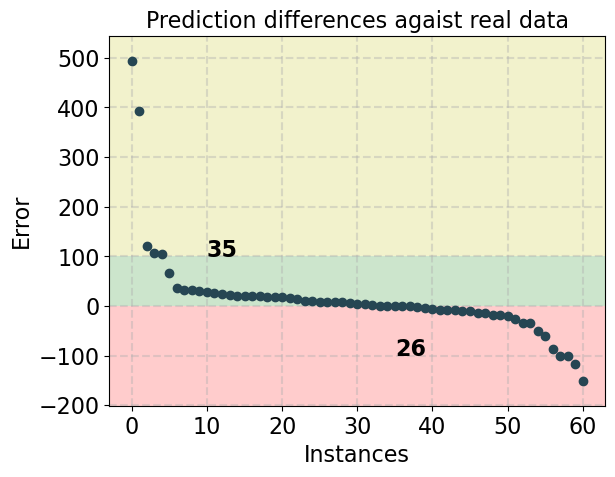

In [101]:
diff = y_test - ypred
diff_ordered = np.sort(diff, axis=0)[::-1]

plt.plot(diff_ordered, 'bo', color='#264653', linewidth=3)
plt.xticks(fontsize=16), plt.yticks(fontsize=16), plt.grid(linestyle='--',linewidth=1.5, alpha = 0.4);
plt.xlabel('Instances', fontsize=16), plt.ylabel('Error', fontsize=16), plt.title('Prediction differences agaist real data', fontsize=16);
plt.ylim(diff_ordered[-1][0]-50, diff_ordered[0][0]+50);
plt.axhspan(0, diff_ordered[-1][0]-50, facecolor='r', alpha=0.2), plt.axhspan(0, 100, facecolor='g', alpha=0.2), plt.axhspan(100, diff_ordered[0][0]+50, facecolor='y', alpha=0.2);
plt.annotate(f"{len(diff_ordered[diff_ordered >= 0])}", xy=(10, 100), xytext=(10, 100), fontsize=16, color='k', fontweight='bold');
plt.annotate(f"{len(diff_ordered[diff_ordered < 0])}", xy=(35, -100), xytext=(35, -100), fontsize=16, color='k', fontweight='bold');

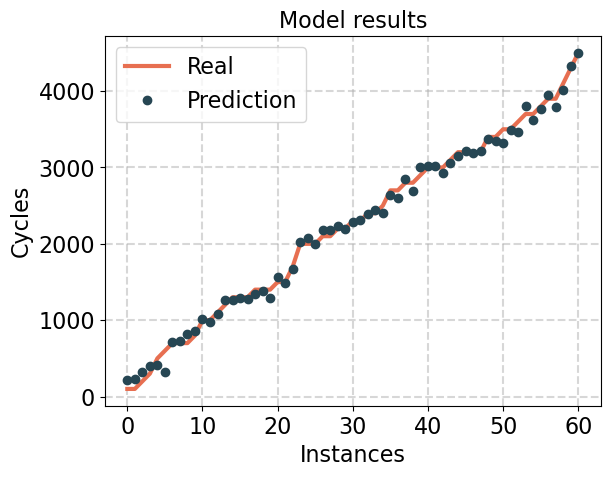

In [126]:
ypred_ordered = ypred[np.argsort(y_test, axis=0)]
y_test_ordered = np.sort(y_test, axis=0)

plt.plot(y_test_ordered,  label='Real', color='#E76F51', linewidth=3);
plt.plot(ypred_ordered.reshape(-1,1), 'bo',label='Prediction', color='#264653', linewidth=1);
plt.xticks(fontsize=16), plt.yticks(fontsize=16), plt.grid(linestyle='--',linewidth=1.5, alpha = 0.5);
plt.xlabel('Instances', fontsize=16), plt.ylabel('Cycles', fontsize=16), plt.title('Model results', fontsize=16);
plt.legend(fontsize=16);